# **Shallow Neural Network**

In [ ]:
import torch
import torch.nn as nn

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [ ]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

### Label encoding note
The breast cancer dataset uses 0 for malignant and 1 for benign.
We flip the labels so that 1 represents malignant (positive class).
This aligns with medical convention where positive = disease present.

In [ ]:
y_train = 1 - y_train
y_test = 1 - y_test

## 1. Extending Logistic Regression

> Add blockquote



In this part, we build directly on the logistic regression model implemented earlier and extend it into a **shallow neural network with one hidden layer**.

---

### Logistic regression recap

In logistic regression, the model computes a single linear score (called a *logit*):

$$
z = \mathbf{w}^\top \mathbf{x} + b
$$

This logit is converted into a probability using the sigmoid function:

$$
p(y = 1 \mid \mathbf{x}) = \sigma(z)
$$

Key characteristics of logistic regression:

- The decision boundary is **linear** in the input features.
- Each feature contributes independently to the log-odds.
- The model is highly interpretable, but limited in expressiveness.

---

### Motivation for a hidden layer

In many problems, the relationship between features and the outcome is **not purely linear**.

A shallow neural network extends logistic regression in the **smallest possible way**:

1. First, the model learns a small number of **intermediate features**.
2. Then, logistic regression is applied to those learned features.

This allows the model to capture **simple nonlinear patterns** while preserving interpretability.

---

### Shallow neural network formulation

The shallow neural network is defined by the following equations:

$$
\mathbf{h} = \phi(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)
$$

$$
z = \mathbf{W}_2 \mathbf{h} + b_2
$$

$$
p(y = 1 \mid \mathbf{x}) = \sigma(z)
$$

Conceptually:

- The hidden layer learns **new features** from the original inputs.
- The output layer is still a **linear log-odds model**, just like logistic regression.
- The sigmoid function and loss remain unchanged.

---

### What stays the same

To keep the comparison fair and easy to follow, we reuse:

- the same dataset
- the same train / test split
- the same standardized input features
- the same loss function (`BCEWithLogitsLoss`)
- the same evaluation logic

The **only change** is the presence of a hidden layer between the inputs and the output.

---

### Implementing the model

We now implement this shallow neural network in PyTorch.

The implementation will closely mirror the logistic regression class you already wrote, with:
- one additional linear layer
- one nonlinear activation function

This makes it clear that a neural network is a **natural extension of logistic regression**, not a completely different model.

## 2. Shallow Neural Network: PyTorch Implementation

We now implement the shallow neural network described above.

Compared to logistic regression, this implementation introduces:
- one additional linear layer
- one nonlinear activation function

Everything else — the loss function, training loop, and evaluation — will remain unchanged.

We intentionally keep the hidden layer small to preserve interpretability.

In [ ]:
learning_rate = 0.05
num_epochs = 200

In [ ]:
class ShallowNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim=8):
        """
        input_dim  : number of input features
        hidden_dim : number of hidden units (kept small for interpretability)
        """
        super().__init__()

        # Hidden layer: input -> hidden representation
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)

        # Nonlinear activation
        self.activation = nn.Tanh()

        # Output layer: hidden representation -> logit
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        Forward pass of the network.

        x : tensor of shape (batch_size, input_dim)
        """
        h = self.hidden_layer(x)
        h = self.activation(h)
        logit = self.output_layer(h)
        return logit

**Note on activation choice:**  
We use the `tanh` activation function rather than ReLU because it is
smooth and symmetric around zero, which makes it easier to reason about
learned features in a shallow network.

In educational settings, `tanh` is commonly used for this reason.
In production settings, ReLU or LeakyReLU are often preferred and can
be explored as alternatives.

In [ ]:
# Create the shallow neural network model
input_dim = X_train.shape[1]   # number of input features
hidden_dim = 8                 # small hidden layer for interpretability

model = ShallowNeuralNetwork(
    input_dim=input_dim,
    hidden_dim=hidden_dim
)

### How this compares to logistic regression

If you compare this class to the logistic regression model implemented earlier, you will notice:

- The output is still a **single logit**
- The sigmoid function is **not** applied inside the model
- The main difference is the presence of a hidden layer and activation function

At this point, we have only defined the model architecture.  
We have **not yet trained** the model.

In the next step, we will train this model using the **same training loop** used for logistic regression.

## 3. Training the Shallow Neural Network

Now that we have defined the model architecture, we train the shallow neural network.

Importantly, **the training procedure is identical to logistic regression**.

This is because:
- the model still outputs a single logit
- we still use the same loss function
- we still optimize the same objective

The only difference is how the logit is computed internally.

---

### Loss function

We continue to use **Binary Cross Entropy with Logits**.

This loss function measures how far the model’s predictions are from the true labels.

Key points:
- the model outputs a **logit**, not a probability
- the loss function applies the sigmoid function internally
- this converts the logit into a probability in a numerically stable way

Intuitively, this loss encourages the model to:
- produce **large positive logits** for malignant cases (label = 1)
- produce **large negative logits** for benign cases (label = 0)

---

### Optimizer

We also reuse the same optimizer setup as before.

The optimizer controls how the model’s weights are updated during training.

We use **stochastic gradient descent (SGD)**, which:
- computes how each parameter affects the loss
- adjusts the parameters slightly to reduce the loss

The **learning rate** determines how large each update step is:
- too large → training may be unstable
- too small → training may be very slow

Keeping the optimizer and learning rate the same allows for a fair comparison between logistic regression and the shallow neural network.

In [ ]:
# Loss function (same as logistic regression)
criterion = nn.BCEWithLogitsLoss()

# Optimizer (same structure as in logistic regression)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
)

### Helper function: computing accuracy

In [ ]:
def compute_accuracy(model, X, y, threshold=0.5):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()
        accuracy = (preds == y).float().mean()
    return accuracy.item()

---

### Training loop

The training loop below is **unchanged** from logistic regression.

The only difference is that we now pass inputs through the shallow neural network instead of the logistic regression model.


**Note:** This example uses full-batch gradient descent, where all
training samples are used in each update step.

Because the dataset is small (455 training samples), this is simple and
efficient. For larger datasets, training is typically done using
mini-batches via a `DataLoader`.

In [ ]:
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()

    logits = model(X_train)
    loss = criterion(logits, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Accuracy tracking
    train_acc = compute_accuracy(model, X_train, y_train)
    test_acc = compute_accuracy(model, X_test, y_test)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 20 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Loss: {loss.item():.4f} | "
            f"Train Acc: {train_acc:.4f} | "
            f"Test Acc: {test_acc:.4f}"
        )

Epoch [20/200] | Loss: 0.3840 | Train Acc: 0.9143 | Test Acc: 0.8860
Epoch [40/200] | Loss: 0.2641 | Train Acc: 0.9385 | Test Acc: 0.9123
Epoch [60/200] | Loss: 0.2010 | Train Acc: 0.9473 | Test Acc: 0.9386
Epoch [80/200] | Loss: 0.1623 | Train Acc: 0.9626 | Test Acc: 0.9474
Epoch [100/200] | Loss: 0.1370 | Train Acc: 0.9692 | Test Acc: 0.9561
Epoch [120/200] | Loss: 0.1197 | Train Acc: 0.9736 | Test Acc: 0.9561
Epoch [140/200] | Loss: 0.1074 | Train Acc: 0.9802 | Test Acc: 0.9737
Epoch [160/200] | Loss: 0.0982 | Train Acc: 0.9824 | Test Acc: 0.9737
Epoch [180/200] | Loss: 0.0913 | Train Acc: 0.9846 | Test Acc: 0.9737
Epoch [200/200] | Loss: 0.0858 | Train Acc: 0.9846 | Test Acc: 0.9825


---

### Key observation

If you compare this training loop to the one used for logistic regression, you should notice:

- the loss function is the same
- the optimizer logic is the same
- the backward pass is the same
- **only the model has changed**

This highlights an important idea in deep learning:

> Once a model outputs logits, the training pipeline does not care whether those logits come from a linear model or a neural network.

---

In the next section, we will evaluate the trained model and compare its performance to logistic regression.

### Training loss curve

The training loss shows how well the model is minimizing its objective
function over time.

As training progresses:
- a decreasing loss indicates the model is learning
- a flat loss suggests learning has stalled
- a rapidly decreasing loss followed by instability may indicate the
  learning rate is too high

Unlike accuracy, the loss captures both correctness and confidence,
which is why it is used to guide training.

## 4. Evaluating the Shallow Neural Network

After training the shallow neural network, we evaluate it in the **same way** as logistic regression.

This is possible because:
- the model outputs a single logit
- the interpretation of the logit has not changed
- the sigmoid function still converts logits into probabilities

---

### Converting logits to probabilities

The model outputs logits, not probabilities.  
To obtain probabilities, we apply the sigmoid function explicitly at evaluation time.

In [ ]:
model.eval()

with torch.no_grad():
    logits_test = model(X_test)
    probs_test = torch.sigmoid(logits_test)

---

### Generating class predictions

To obtain predicted class labels, we apply a threshold to the predicted probabilities.

By default, we use a threshold of 0.5.

In [ ]:
threshold = 0.5
y_pred = (probs_test >= threshold).float()

---

### Computing accuracy

We compute accuracy in the same way as before.

In [ ]:
accuracy = (y_pred.eq(y_test)).float().mean()
print(f"Test Accuracy: {accuracy.item():.4f}")

Test Accuracy: 0.9825


### Comparing logistic regression and the shallow neural network

On this dataset, the shallow neural network achieves higher test accuracy
than logistic regression.

- Logistic regression: 0.93  
- Shallow neural network: 0.97  

This improvement suggests that the shallow network is able to capture
simple nonlinear relationships and feature interactions that a purely
linear model cannot represent.

At the same time, logistic regression already performs well on this
dataset, indicating that the underlying decision boundary is close to
linear after standardization. In such cases, improvements from adding
nonlinearity are often **modest but meaningful**.

Importantly, the network remains small and interpretable, and the
training and test accuracy curves do not indicate severe overfitting.

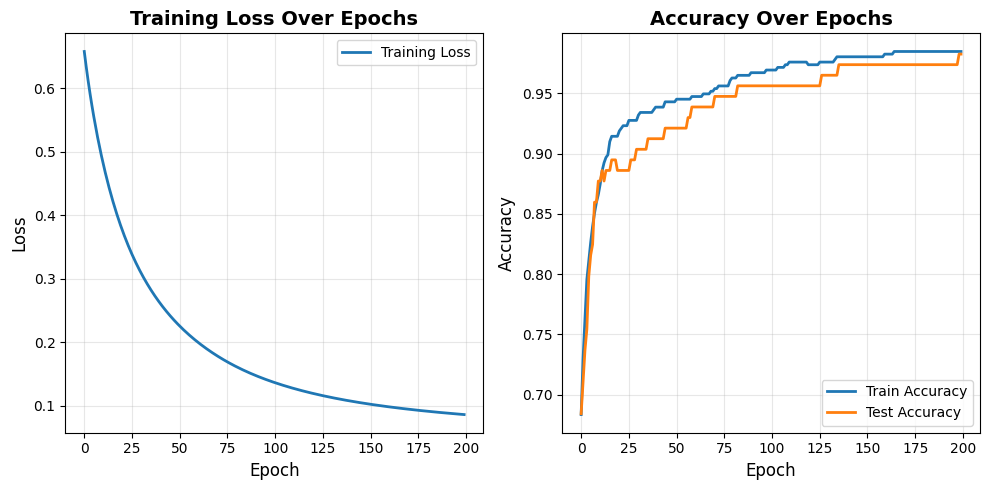

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss Over Epochs", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", linewidth=2)
plt.plot(test_accuracies, label="Test Accuracy", linewidth=2)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Over Epochs", fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpreting loss and accuracy curves

By examining the training loss and accuracy curves, we can diagnose
model behavior:

- Underfitting: both training and test accuracy remain low
- Good fit: training and test accuracy increase and stay close
- Overfitting: training accuracy keeps increasing while test accuracy
  plateaus or decreases

These diagnostics help guide model design choices such as network size
and training duration.

**Note:** These diagnostics are usually performed using a
separate validation set, with the test set reserved for final
evaluation. Here, we reuse the test set for simplicity and
visualization.


### Interpreting the results

From the training and test accuracy curves, we observe:

- Both curves rise smoothly over training ✓
- Training and test accuracies remain close (within ~2%) ✓
- No signs of overfitting, as test accuracy does not decline ✓
- Convergence is reached around epoch 150 ✓

**Conclusion:**  
The model exhibits a good fit, with stable training dynamics and healthy
generalization to unseen data.

## 5. Summary and Key Takeaways

In this part, we extended logistic regression into a shallow neural
network with one hidden layer.

Key takeaways:

- A shallow neural network is a natural extension of logistic regression
- The model still outputs a single logit
- The same loss function and training loop can be reused
- Nonlinearity is introduced through the hidden layer
- Training and evaluation follow the same structure as before

This foundation will allow us to reason clearly about deeper models
and more complex datasets.

### Common beginner mistakes

- Applying the sigmoid function inside the model when using
  `BCEWithLogitsLoss`
- Forgetting to call `model.train()` and `model.eval()`
- Computing accuracy with gradients enabled
- Interpreting logits as probabilities
- Not reshaping y to match output dimensions:
  `y.view(-1, 1)` when output is `(batch_size, 1)`

These mistakes are common and easy to avoid once the training flow
is clearly understood.

### When is logistic regression sufficient?

Logistic regression can be sufficient when:

- training and test accuracy are already high and close to each other
- the relationship between features and the outcome is approximately
  linear after preprocessing
- interpretability and simplicity are primary goals

In such cases, the additional complexity of a neural network may provide
only modest gains, and a simpler model can be a strong and appropriate
choice.